# <center> **Machine Learning**


---


# <center> PROJECT 2 2024


Θα χρησιμοποιήσουμε νευρωνικά δίκτυα για να προβλέψουμε είδη μουσικής από σύντομα μουσικά κλιπ, το καθένα από τα οποία διαρκεί μόλις 1 δευτερόλεπτο. Στόχος μας είναι να χαρακτηρίσουμε αυτά τα κλιπ ως κλασικά, ποπ, ροκ ή μπλουζ. Τροφοδοτούμε MFCCs σε Feedforward Neural Networks και mel spectrograms σε Convolutional Neural Networks για να κάνουμε αυτές τις προβλέψεις.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import torch.nn.functional as F
import random
import librosa.display
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import f1_score,confusion_matrix
import time
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

Mounted at /content/gdrive


# **Question 1:**
---
**Step 1: Load data (mfccs)**

In [ ]:

#device = 'cpu'
# Mapping labels to integers
labels_map = {
    "hiphop": 2,
    "blues": 0,
    "classical": 1,
    "rock_metal_hardrock": 3,
}

#Convert labels from strings to ints.
def string_to_int(string_labels):
    return [labels_map[label] for label in string_labels]

trainX = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/train/mfccs/X.npy')
testX = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/test/mfccs/X.npy')
valX = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/val/mfccs/X.npy')

string_labels = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/train/mfccs/labels.npy')
trainL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/test/mfccs/labels.npy')
testL = string_to_int(string_labels)
string_labels = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/val/mfccs/labels.npy')
valL = string_to_int(string_labels)


# Prepare DataLoaders
train = TensorDataset(torch.tensor(trainX), torch.tensor(trainL))
test = TensorDataset(torch.tensor(testX), torch.tensor(testL))
val = TensorDataset(torch.tensor(valX), torch.tensor(valL))

#loading datasets to dataloaders.
train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True)

**Step 2: Feedforward Neural Network**

Ορίζουμε ένα Feedforward Neural Network, χρησιμοποιώντας 4 γραμμικά επίπεδα.

In [ ]:
class NeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(NeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        ## image 26 --> 126 --> 32 --> 4
        self.linear_stack = nn.Sequential(
            nn.Linear(26, 128),  ##torch.nn.Linear(in_features, out_features) 26-->128
            nn.Linear(128, 32),    ## 128-->32
            nn.Linear(32, 4),     ##32 -->4
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits


**Step 3: Train function**

Ορίζουμε μια συνάρτηση εκπαίδευσης η οποία, δεδομένων των παραμέτρων για την εκπαίδευση ενός μοντέλου, εκτελεί τη διαδικασία εκπαίδευσης.

In [ ]:
def train_loop(epochs,dataloader, model, loss_fn, optimizer,device,validation_check=None,best_name=None,print_output=None):
  size = len(dataloader.dataset)
  best_f1_score = -1
  for num_epoch in range(epochs):
    losses = []
    model.train()  # Ensure model is in training mod
    for X, y in dataloader:

        # if using gpu dont forget to move the data there
        X = X.to(device, dtype=torch.float32)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        losses.append(loss.item())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#find best model
    if (validation_check) :
        _,_,_, _, f1,_ = test_loop(val_dataloader, model, loss_fn,device)
        if (best_f1_score < f1) :
          best_f1_score = f1
          torch.save(model.state_dict(), best_name)

    if(print_output):
      print(f"Epoch {num_epoch+1}\n-------------------------------")
      print("Training Loss:", np.mean(losses))

  print("Done!")
  return model


**Step 4: Test function**

Ορίζουμε μια συνάρτηση η οποία, δεδομένου ενός dataloader, και ενός μοντέλου, αξιολογεί τα δεδομένα αυτού του dataloader, χρησιμοποιώντας τη δεδομένη συνάρτηση απώλειας και τις προβλέψεις που δημιουργούνται από το μοντέλο.

In [ ]:
def test_loop(dataloader, model, loss_fn,device):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []

    model.eval()  # Set the model to evaluation mode
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device, dtype=torch.float32)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            y_pred.extend((pred.argmax(1)).cpu().numpy())
            y_true.extend(y.cpu().numpy())
    test_loss /= size
    correct /= size
    f1 = f1_score(y_true, y_pred, average = 'macro')
    conf = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    return y_true,y_pred,test_loss, correct, f1, conf


**Step 5-6: Train FNN with CPU-GPU**

In [ ]:
# Helper function to measure execution time
def measure_time(device, train_dataloader, test_dataloader):
    num_epochs=30
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

    start = time.time()
    model = train_loop(num_epochs, train_dataloader, model, loss_fn, optimizer,device,print_output=True)
    _,_,test_loss, accuracy, f1, conf = test_loop(test_dataloader, model, loss_fn,device)
    end = time.time()

    return end - start, test_loss, accuracy, f1, conf

# Measure time on CPU
cpu_device = torch.device('cpu')
cpu_time, cpu_test_loss, cpu_accuracy, cpu_f1, cpu_conf = measure_time(cpu_device, train_dataloader, test_dataloader)

# Measure time on GPU
gpu_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_time, gpu_test_loss, gpu_accuracy, gpu_f1, gpu_conf = measure_time(gpu_device, train_dataloader, test_dataloader)

# Print results
print("\n----Evaluation:----\n")
print(f"CPU Time: {cpu_time:.2f} sec")
print(f"GPU Time: {gpu_time:.2f} sec")
print(f"Time Difference: {cpu_time - gpu_time:.2f} sec")
print(f"\nCPU Test Error: \n Accuracy: {(cpu_accuracy * 100):>0.1f}%, Avg loss: {cpu_test_loss:>8f}, macro F1 score: {cpu_f1 * 100:.2f}%, \nconfusion matrix: \n{cpu_conf} \n")
print(f"GPU Test Error: \n Accuracy: {(gpu_accuracy * 100):>0.1f}%, Avg loss: {gpu_test_loss:>8f}, macro F1 score: {gpu_f1 * 100:.2f}%, \nconfusion matrix: \n{gpu_conf} \n")

Epoch 1
-------------------------------
Training Loss: 1.3926198655366897
Epoch 2
-------------------------------
Training Loss: 1.357144564986229
Epoch 3
-------------------------------
Training Loss: 1.3258423322439195
Epoch 4
-------------------------------
Training Loss: 1.2990375125408173
Epoch 5
-------------------------------
Training Loss: 1.270269546508789
Epoch 6
-------------------------------
Training Loss: 1.2410789549350738
Epoch 7
-------------------------------
Training Loss: 1.211320920586586
Epoch 8
-------------------------------
Training Loss: 1.1817911314964293
Epoch 9
-------------------------------
Training Loss: 1.1574318125844
Epoch 10
-------------------------------
Training Loss: 1.1328363427519799
Epoch 11
-------------------------------
Training Loss: 1.109114202260971
Epoch 12
-------------------------------
Training Loss: 1.0915639287233352
Epoch 13
-------------------------------
Training Loss: 1.0715258783102035
Epoch 14
-------------------------------


Βλέπουμε πως στο συγκεκριμένο σημείο τα score ειναι πάνω κάτω το ίδιο, ωστόσο η εκτέλεση με GPU είναι λίγο πιο αργή.

**Step 7: Model Selection**

Τώρα θα εκπαιδεύσουμε το ίδιο νευρωνικό δίκτυο, αλλά θα αξιολογήσουμε το μοντέλο που παράγεται μετά από κάθε εποχή στο σύνολο επικύρωσης και θα αποθηκεύσουμε το καλύτερο για να το αξιολογήσουμε στο σύνολο δεδομένων δοκιμής.

In [ ]:
# define number of epochs
num_epochs = 30
# define the loss function
loss_fn = nn.CrossEntropyLoss()
# define the learning rate
learning_rate =  0.002

In [ ]:
device = 'cpu'
model = NeuralNetwork().to(device)  ##assing model to device

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device,validation_check=True,best_name='best_fnn_model',print_output=True)
model = NeuralNetwork()
model.load_state_dict(torch.load('best_fnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Epoch 1
-------------------------------
Training Loss: 1.396993743777275
Epoch 2
-------------------------------
Training Loss: 1.3595903241634368
Epoch 3
-------------------------------
Training Loss: 1.3405760878324509
Epoch 4
-------------------------------
Training Loss: 1.3136465007066727
Epoch 5
-------------------------------
Training Loss: 1.2871741682291031
Epoch 6
-------------------------------
Training Loss: 1.2679738968610763
Epoch 7
-------------------------------
Training Loss: 1.2378029507398605
Epoch 8
-------------------------------
Training Loss: 1.208441013097763
Epoch 9
-------------------------------
Training Loss: 1.1777157816290855
Epoch 10
-------------------------------
Training Loss: 1.1495566669106483
Epoch 11
-------------------------------
Training Loss: 1.1233208256959915
Epoch 12
-------------------------------
Training Loss: 1.098085528612137
Epoch 13
-------------------------------
Training Loss: 1.0749767625331879
Epoch 14
----------------------------

# **Question 2:**
---
**Step 1: Load data (Spectograms)**

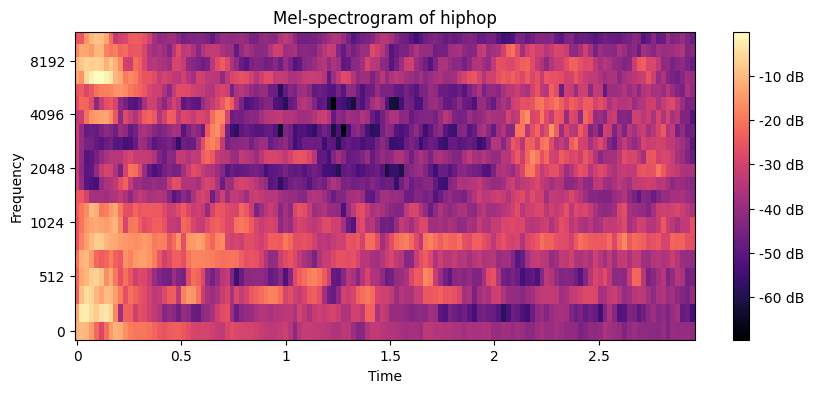

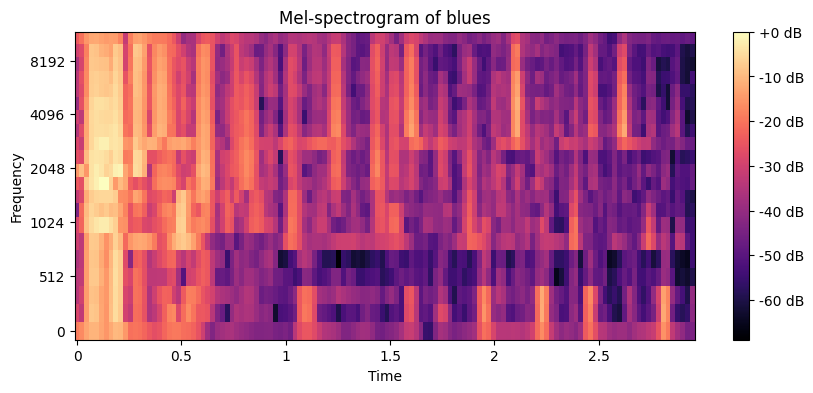

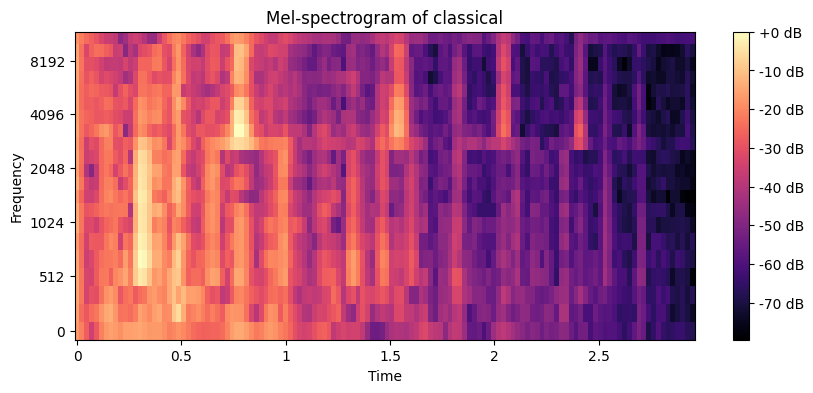

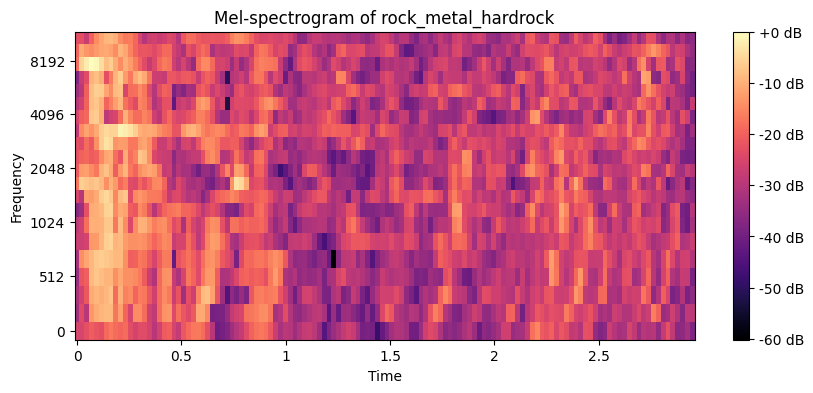

In [ ]:

#device = 'cpu'
# Mapping labels to integers
labels_map = {
    "hiphop": 2,
    "blues": 0,
    "classical": 1,
    "rock_metal_hardrock": 3,
}

def string_to_int(string_labels):
    return [labels_map[label] for label in string_labels]

trainX = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/train/melgrams/X.npy')
testX = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/test/melgrams/X.npy')
valX = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/val/melgrams/X.npy')

string_labels = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/train/melgrams/labels.npy')
trainL = string_to_int(string_labels)

string_labels = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/test/melgrams/labels.npy')
testL = string_to_int(string_labels)

string_labels = np.load('/content/gdrive/MyDrive/ml/music_genre_data_di/val/melgrams/labels.npy')
valL = string_to_int(string_labels)



# Prepare DataLoaders
train = TensorDataset(torch.tensor(trainX), torch.tensor(trainL))
test = TensorDataset(torch.tensor(testX), torch.tensor(testL))
val = TensorDataset(torch.tensor(valX), torch.tensor(valL))


train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True)

# Define function to plot a mel-spectrogram with class label
def plot_melgram(melgram, class_name):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(melgram, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-spectrogram of {class_name}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

# Plot a random melgram from each class
for class_name,class_idx  in labels_map.items():
    flag = False
    while not flag:
        sample_idx = random.randint(0, len(trainX) - 1)
        if trainL[sample_idx] == class_idx:
            flag = True
            plot_melgram(trainX[sample_idx], class_name)

**Step 2: Convolutional Neural Network**

Ορίζουμε ένα συνελικτικό νευρωνικό δίκτυο με 5 κανάλια, η έξοδος του οποίου δίνεται ως είσοδος σε ένα πλήρως συνδεδεμένο νευρωνικό δίκτυο που αποτελείται από 4 κρυφά επίπεδα.

In [ ]:

import torch.nn as nn

class Convolutional_Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)

    self.flatten = nn.Flatten()

    self.linear_stack = nn.Sequential(
            nn.Linear(71680, 1024),  ##torch.nn.Linear(in_features, out_features) 71680-->1024
            nn.Linear(1024, 256),    ## 1024-->256
            nn.Linear(256, 32),   ##256 -->32
            nn.Linear(32, 4),     ##32 -->4
        )

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)

      x = self.flatten(x)

      x = self.linear_stack(x)

      return x

**Step 3: Train CNN**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Convolutional_Neural_Network().to(device)  #assing model to device

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model',print_output=True)
model = Convolutional_Neural_Network()
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Epoch 1
-------------------------------
Training Loss: nan
Epoch 2
-------------------------------
Training Loss: nan
Epoch 3
-------------------------------
Training Loss: nan
Epoch 4
-------------------------------
Training Loss: nan
Epoch 5
-------------------------------
Training Loss: nan
Epoch 6
-------------------------------
Training Loss: nan
Epoch 7
-------------------------------
Training Loss: nan
Epoch 8
-------------------------------
Training Loss: nan
Epoch 9
-------------------------------
Training Loss: nan
Epoch 10
-------------------------------
Training Loss: nan
Epoch 11
-------------------------------
Training Loss: nan
Epoch 12
-------------------------------
Training Loss: nan
Epoch 13
-------------------------------
Training Loss: nan
Epoch 14
-------------------------------
Training Loss: nan
Epoch 15
-------------------------------
Training Loss: nan
Epoch 16
-------------------------------
Training Loss: nan
Epoch 17
-------------------------------
Training

Είναι προφανές ότι το δίκτυο δεν μπορεί να εκπαιδευτεί, γεγονός που οφείλεται στο ότι η απώλεια προπόνησης αυξάνεται συνεχώς. Η τελική βαθμολογία F1 στο σύνολο δεδομένων δοκιμής είναι μόνο 9%.

**Step 4: Pooling-Padding**

Γι αυτό το λόγο χρησιμοποιούμε max pooling με kernel size=2 και padding=2.

In [ ]:

class Convolutional_Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding=2)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

    self.flatten = nn.Flatten()
    self.max_pool = nn.MaxPool2d(kernel_size=2)

    self.linear_stack = nn.Sequential(
            nn.Linear(1024, 1024),  ##torch.nn.Linear(in_features, out_features) 1024-->1024
            nn.Linear(1024, 256),    ## 1024-->256
            nn.Linear(256, 32),   ##256 -->32
            nn.Linear(32, 4),     ##32 -->4
        )

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.max_pool(self.conv1(x))
      x = self.max_pool(self.conv2(x))
      x = self.max_pool(self.conv3(x))
      x = self.max_pool(self.conv4(x))

      x = self.flatten(x)

      x = self.linear_stack(x)

      return x

In [ ]:
# define number of epochs
num_epochs = 30
# define the loss function
loss_fn = nn.CrossEntropyLoss()
# define the learning rate
learning_rate =  0.002

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Convolutional_Neural_Network().to(device)  ##assing model to device

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model',print_output=True)
model = Convolutional_Neural_Network()
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Epoch 1
-------------------------------
Training Loss: 1.3355626863241197
Epoch 2
-------------------------------
Training Loss: 1.1871656295657158
Epoch 3
-------------------------------
Training Loss: 1.0326383626461029
Epoch 4
-------------------------------
Training Loss: 0.9303363659977912
Epoch 5
-------------------------------
Training Loss: 0.8475657303631305
Epoch 6
-------------------------------
Training Loss: 0.7885196845233441
Epoch 7
-------------------------------
Training Loss: 0.7434751050174236
Epoch 8
-------------------------------
Training Loss: 0.7067115913331509
Epoch 9
-------------------------------
Training Loss: 0.6664017661660909
Epoch 10
-------------------------------
Training Loss: 0.6441626574099064
Epoch 11
-------------------------------
Training Loss: 0.6003832390904427
Epoch 12
-------------------------------
Training Loss: 0.5870263357460499
Epoch 13
-------------------------------
Training Loss: 0.5433645688742399
Epoch 14
-------------------------

Παρατηρούμε πως τώρα το νευρωνικό εκπαιδεύεται ενώ η απόδοση του έχει αυξηθεί κατα πολύ με f1 score=72.9%

**Step 5: Activation functions**

Εδώ χρησιμοποιούμε για activation function την ReLU

In [ ]:


class Convolutional_Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding=2)  ##in out kernel
    self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

    self.max_pool = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()

    self.linear_stack = nn.Sequential(
            nn.Linear(1024, 1024),  ##torch.nn.Linear(in_features, out_features) 1024-->1024
            nn.ReLU(),
            nn.Linear(1024, 256),    ## 1024-->256
            nn.ReLU(),
            nn.Linear(256, 32),   ##256 -->32
            nn.ReLU(),
            nn.Linear(32, 4),     ##32 -->4
        )

  def forward(self, x):
      x = torch.unsqueeze(x,1)

      x = self.max_pool(F.relu(self.conv1(x)))
      x = self.max_pool(F.relu(self.conv2(x)))
      x = self.max_pool(F.relu(self.conv3(x)))
      x = self.max_pool(F.relu(self.conv4(x)))

      x = self.flatten(x)

      x = self.linear_stack(x)

      return x

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Convolutional_Neural_Network().to(device)  ##assing model to device


# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model')
model = Convolutional_Neural_Network()
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Done!

----Evaluation:----

Test Error: 
 Accuracy: 66.6%, Avg loss: 0.049876, macro F1 score: 67.55482479014454%, 
confusion matrix: 
[[205   8  50  61]
 [ 69 213  15   0]
 [ 36   1 284  35]
 [103   5  76 215]] 



Εδώ βλέπουμε πως χρησιμοποιώντας activation function σε κάθε συνελικτικό επίπεδο, η απόδοση πέφτει, ωστόσο αυτό θα αλλάξει όταν χρησιμοποιήσουμε batch normalizaiton.

# **Question 3:**
---
**Step 1: Seed**

Add a seed to every possible library.

In [ ]:
# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)



Χρησιμοποιώντας το seed που δώσαμε παραπάνω, εκπαιδεύουμε τώρα το βασικό μας μοντέλο, προκειμένου να χρησιμοποιήσουμε τα αποτελέσματά του ως αναφορά αργότερα.

In [ ]:
set_seed(42)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Convolutional_Neural_Network().to(device)  ##assing model to device


# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model',print_output=True)
model = Convolutional_Neural_Network()
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Epoch 1
-------------------------------
Training Loss: 1.3788252967596053
Epoch 2
-------------------------------
Training Loss: 1.3356326115131378
Epoch 3
-------------------------------
Training Loss: 1.2562288650870324
Epoch 4
-------------------------------
Training Loss: 1.209403680562973
Epoch 5
-------------------------------
Training Loss: 1.1559573635458946
Epoch 6
-------------------------------
Training Loss: 1.1070733198523521
Epoch 7
-------------------------------
Training Loss: 1.0726344618201256
Epoch 8
-------------------------------
Training Loss: 1.0553993245959281
Epoch 9
-------------------------------
Training Loss: 1.03471975505352
Epoch 10
-------------------------------
Training Loss: 1.01705517411232
Epoch 11
-------------------------------
Training Loss: 0.9924596413969994
Epoch 12
-------------------------------
Training Loss: 0.9648828825354576
Epoch 13
-------------------------------
Training Loss: 0.9427045831084251
Epoch 14
------------------------------

Το F1-Score  είναι 64.5%. Να σημειωθεί πως για την εκτέλεση αυτη εχει χρησιμοποιηθει relu activation function.

**Step 2: Optimizers**

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)
model = Convolutional_Neural_Network().to(device)  ##assing model to device
# define the optimizer object
optimizers = [(torch.optim.Adadelta(model.parameters(), lr=learning_rate), "adadelta"),
              (torch.optim.Adagrad(model.parameters(), lr=learning_rate), "adagrad"),
              (torch.optim.Adam(model.parameters(), lr=learning_rate), "adam"),
              (torch.optim.AdamW(model.parameters(), lr=learning_rate), "adamw"),
              (torch.optim.Adamax(model.parameters(), lr=learning_rate), "adamax"),
              (torch.optim.ASGD(model.parameters(), lr=learning_rate), "asgd"),
              (torch.optim.NAdam(model.parameters(), lr=learning_rate), "nadam"),
              (torch.optim.RAdam(model.parameters(), lr=learning_rate), "radam"),
              (torch.optim.SGD(model.parameters(), lr=learning_rate), "sgd")]

for optimizer, optimizer_name in optimizers:
    set_seed(42)
    print("\n-----", optimizer_name, "-----")

    new_model = train_loop(30,train_dataloader, model, loss_fn, optimizer,device,validation_check=True,best_name='best_cnn_model')
    new_model = Convolutional_Neural_Network()
    new_model.load_state_dict(torch.load('best_cnn_model'))
    new_model = new_model.to(device)
    (_,_,test_loss, correct, f1,_) = test_loop(test_dataloader, new_model, loss_fn,device)

    # Print results
    print("\n----Evaluation:----\n")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%\n")



----- adadelta -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 50.4%, Avg loss: 0.066060, macro F1 score: 50.77694177067461%


----- adagrad -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.048857, macro F1 score: 72.8444870523975%


----- adam -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.053215, macro F1 score: 70.55872269820179%


----- adamw -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 68.2%, Avg loss: 0.057996, macro F1 score: 68.69720278723813%


----- adamax -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 68.8%, Avg loss: 0.260879, macro F1 score: 69.29194021029663%


----- asgd -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 68.2%, Avg loss: 0.331090, macro F1 score: 68.5297380386918%


----- nadam -----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 68.1%, Avg loss: 0.134362, macro F1 score: 68.69558406903217%


----- radam -----
Done!

----Evaluation:----

Test Error: 


<center>

| <font size="4" rowspan="2">Metrics/Algorithm</font>    | <font size="4">adadelta</font> | <font size="4">adagram</font> | <font size="4">adam</font> | <font size="4">adamw</font> | <font size="4">adamax</font> | <font size="4">asgd</font> | <font size="4">nadam</font> | <font size="4">radam</font> | <font size="4">sgd</font> |
|------------|----------|---------|------|-------|--------|------|------|-------|-----|
| <font size="4">Accuracy</font>   | <font size="4">50.4%</font> | <font size="4">72.5%</font> | <font size="4">69.5%</font> | <font size="4">68.2%</font> | <font size="4">68.8%</font> | <font size="4">68.2%</font> | <font size="4">68.1%</font> | <font size="4">67.2%</font> | <font size="4">67.8%</font> |
| <font size="4">f1 score</font>   | <font size="4">50.7%</font> | <font size="4">72.8%</font> | <font size="4">70.5%</font> | <font size="4">68.6%</font> | <font size="4">69.2%</font> | <font size="4">68.5%</font> | <font size="4">68.6%</font> | <font size="4">68.1%</font> | <font size="4">68.4%</font> |

</center>


Βλέπουμε πως ο καλύτερος optimizer με βάση το accuracy και το f1 score  είναι ο Adagrad ενώ με διαφορά ο χειρότερος ο adadelta.

Οι υπόλοιποοι έχουν περίπου την ίδια απόδοση.

Να σημειωθεί πως για την εκτέλεση αυτη  εχει χρησιμοποιηθει relu activation function.

**Step 3: Batch Normalization**

Τώρα θα προσθέσουμε batch normalization 2d πριν από κάθε activation ενός convolutional layer.

In [ ]:
class Convolutional_Neural_Network(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding=2)  ##in out kernel
    self.bn1 = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
    self.bn3 = nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
    self.bn4 = nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()


    self.linear_stack = nn.Sequential(
            nn.Linear(1024, 1024),  ##torch.nn.Linear(in_features, out_features) 1024-->1024
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 256),    ## 1024-->256
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 32),   ##256 -->32
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 4),     ##32 -->4

        )

  def forward(self, x):
        x = torch.unsqueeze(x, 1)  # Add channel dimension

        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.max_pool(F.relu(self.conv3(x)))
        x = self.max_pool(F.relu(self.conv4(x)))

        x = self.flatten(x)

        x = self.linear_stack(x)

        return x

Χρησιμοποιούμε τον optimizer με την καλύτερη απόδοση.

In [ ]:
set_seed(42)
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Convolutional_Neural_Network().to(device)  ##assing model to device


# define the optimizer object
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)


model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model')
model = Convolutional_Neural_Network()
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Done!

----Evaluation:----

Test Error: 
 Accuracy: 74.8%, Avg loss: 0.044633, macro F1 score: 75.00177177461873%, 
confusion matrix: 
[[203  20  74  27]
 [ 11 283   1   2]
 [ 41   3 303   9]
 [ 98  18  43 240]] 



Παρατηρούμε πως έχουμε μεγάλη βετλίωση στο f1-score από 64.5% σε 75%.

**Step 4: Regularization**

Εδώ θα δοκιμάσουμε μερικές τιμές του weight decay για να δούμε πως μεταβάλλεται η απόδοση του μοντέλου.

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for weight_decay in [0.001, 0.0001, 0.00001, 0.000001]:
  set_seed(42)

  print("\n---- weight decay =", weight_decay, "----")
  # define the optimizer object
  model = Convolutional_Neural_Network().to(device)  ##assing model to device
  optimizer = optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model')
  model = Convolutional_Neural_Network()
  model.load_state_dict(torch.load('best_cnn_model'))
  model = model.to(device)
  (_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

  # Print results
  print("\n----Evaluation:----\n")
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")



---- weight decay = 0.001 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 73.1%, Avg loss: 0.046123, macro F1 score: 73.06859874036329%, 
confusion matrix: 
[[184  32  58  50]
 [ 16 272   3   6]
 [ 28   2 313  13]
 [ 98  14  50 237]] 


---- weight decay = 0.0001 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 73.1%, Avg loss: 0.043696, macro F1 score: 74.07277637612839%, 
confusion matrix: 
[[247  11  46  20]
 [ 35 256   3   3]
 [ 58   2 292   4]
 [145   8  35 211]] 


---- weight decay = 1e-05 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.048015, macro F1 score: 74.6863881842978%, 
confusion matrix: 
[[195  29  38  62]
 [ 14 277   1   5]
 [ 39   5 288  24]
 [ 83  16  35 265]] 


---- weight decay = 1e-06 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 72.8%, Avg loss: 0.048868, macro F1 score: 73.52382213558587%, 
confusion matrix: 
[[206  17  39  62]
 [ 23 268   3   3]
 [ 52   3 275  26]
 [102  14  30 253]] 



In [ ]:
class Convolutional_Neural_Network(nn.Module):
  def __init__(self,dropout):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5, padding=2)  ##in out kernel
    self.bn1 = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
    self.bn3 = nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
    self.bn4 = nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()


    self.linear_stack = nn.Sequential(
            nn.Linear(1024, 1024),  ##torch.nn.Linear(in_features, out_features) 1024-->1024
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 256),    ## 1024-->256
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 32),   ##256 -->32
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 4),     ##32 -->4

        )

  def forward(self, x):
        x = torch.unsqueeze(x, 1)  # Add channel dimension

        x = self.max_pool(F.relu(self.bn1(self.conv1(x))))
        x = self.max_pool(F.relu(self.bn2(self.conv2(x))))
        x = self.max_pool(F.relu(self.bn3(self.conv3(x))))
        x = self.max_pool(F.relu(self.bn4(self.conv4(x))))

        x = self.flatten(x)
        x = self.linear_stack(x)

        return x

Εδώ θα δοκιμάσουμε μερικές τιμές του dropout στα γραμμικά επίπεδα για να δούμε πως μεταβάλλεται η απόδοση του μοντέλου.

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for dropout in [0.4, 0.5, 0.6]:
  set_seed(42)

  print("\n---- dropout =", dropout, "----")
  # define the optimizer object
  model = Convolutional_Neural_Network(dropout).to(device)  ##assing model to device

  optimizer = optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

  model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model')
  model = Convolutional_Neural_Network(dropout)
  model.load_state_dict(torch.load('best_cnn_model'))
  model = model.to(device)
  (_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

  # Print results
  print("\n----Evaluation:----\n")
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")



---- dropout = 0.4 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.040858, macro F1 score: 76.89253085709133%, 
confusion matrix: 
[[233  14  52  25]
 [ 19 273   2   3]
 [ 47   3 291  15]
 [101  13  32 253]] 


---- dropout = 0.5 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 76.2%, Avg loss: 0.042809, macro F1 score: 76.63927957536806%, 
confusion matrix: 
[[228  12  68  16]
 [ 12 281   2   2]
 [ 38   6 306   6]
 [108  14  43 234]] 


---- dropout = 0.6 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 76.4%, Avg loss: 0.044980, macro F1 score: 76.48196985675426%, 
confusion matrix: 
[[197  20  67  40]
 [ 13 282   1   1]
 [ 33   4 309  10]
 [ 86  13  37 263]] 



Εδώ τεστάρουμε την απόδοση του μοντέλου για αριθμο εποχών=60 και με τις καλύτερες τιμές που βρήκαμε για weight decay και dropout

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs=60
for weight_decay, dropout in [(0.00001, 0.0), (0, 0.5), (0.00001, 0.5)]:

  print("\n---- dropout =", dropout, "---- weight_decay =", weight_decay, "----")
  set_seed(42)
  # define the optimizer object
  model = Convolutional_Neural_Network(dropout).to(device)  ##assing model to device

  optimizer = optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  new_model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model')
  new_model = Convolutional_Neural_Network(dropout)
  new_model.load_state_dict(torch.load('best_cnn_model'))
  new_model = new_model.to(device)
  (_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, new_model, loss_fn,device)

  # Print results
  print("\n----Evaluation:----\n")
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")



---- dropout = 0.0 ---- weight_decay = 1e-05 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 74.6%, Avg loss: 0.043400, macro F1 score: 75.34673488845856%, 
confusion matrix: 
[[231  11  32  50]
 [ 22 270   1   4]
 [ 59   4 273  20]
 [ 95  20  31 253]] 


---- dropout = 0.5 ---- weight_decay = 0 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 76.2%, Avg loss: 0.042809, macro F1 score: 76.63927957536806%, 
confusion matrix: 
[[228  12  68  16]
 [ 12 281   2   2]
 [ 38   6 306   6]
 [108  14  43 234]] 


---- dropout = 0.5 ---- weight_decay = 1e-05 ----
Done!

----Evaluation:----

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.041299, macro F1 score: 78.11327531506484%, 
confusion matrix: 
[[240  20  39  25]
 [  8 288   0   1]
 [ 55   4 284  13]
 [103  17  23 256]] 



Παρατηρούμε πως για dropout=0.5 kai weight decay=1e-05 η απόδοση γίνεται ακόμα καλύτερη.

# **Question 4: Testing**


---


**Step 1: Inference**

Θα χρησιμοποιηθεί η test_loop που έχουμε ήδη υλοποιήσει στα προηγούμενα ερωτήματα.

**Step 2: Downloading Music from youtube**

In [ ]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl
!python3 -m pip install -U yt-dlp #youtube-dl has not been updated for some years and
                                  #does not work anymore, so we use an alternative

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,885 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,389 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,439 kB]
Get:13 ht

In [ ]:
# Step 1: Install the necessary libraries
!pip install pytube pydub

# Step 2: Import the libraries
from pytube import YouTube
from pydub import AudioSegment
import os

def download_youtube(url):
    # command = f'youtube-dl --extract-audio --audio-format wav --output temp.wav --postprocessor-args "-ar 8000" ' + url + " --quiet"
    command = f'yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" ' + url + " --quiet"
    os.system(command)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.0 MB/s eta 0:00:00


Functions from youtube.py to download the music of a youtube video.

In [ ]:
import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url, name, kind):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save(kind+"_"+name+"_melgrams.npy", melgrams)
    os.remove("temp.wav")

Κατεβάζουμε μουσική απο το youtube για να τα χρησιμοποιήουμε στις προβλέψεις μας.

In [ ]:
blues_urls = {
    "BBKing_HowBlueCanYouGet":"https://www.youtube.com/watch?v=l45f28PzfCI",
    "BBKing_TheThrillIsGone": "https://www.youtube.com/watch?v=kpC69qIe02E",
}

classical_urls = {
    "Chopin_Nocturne9":"https://www.youtube.com/watch?v=9E6b3swbnWg",

}

hiphop_urls = {
    "Madonna_HungUp":"https://www.youtube.com/watch?v=EDwb9jOVRtU",
    "50cent_InDaClub":"https://www.youtube.com/watch?v=5qm8PH4xAss",
}

rock_urls = {
    "Placebo_EveryYouEveryMe" : "https://www.youtube.com/watch?v=OMaycNcPsHI",
}

for key in blues_urls:
    youtube_to_melgram(blues_urls[key], key, "blues")

for key in classical_urls:
    youtube_to_melgram(classical_urls[key], key, "classical")

for key in hiphop_urls:
    youtube_to_melgram(hiphop_urls[key], key, "hiphop")

for key in rock_urls:
    youtube_to_melgram(rock_urls[key], key, "rock")

Εκπαιδεύουμε ένα μοντέλο με τα καλύτερα optimizations που βρήκαμε και να το χρησιμοποιήσουμε αργότερα στην μουσική απο το youtube

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs=30
dropout=0.5
weight_decay=0.00001

set_seed(42)
train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=False)
val_dataloader = DataLoader(val, batch_size=16, shuffle=True)


model = Convolutional_Neural_Network(dropout).to(device)  ##assing model to device

optimizer = optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

model = train_loop(num_epochs,train_dataloader, model, loss_fn, optimizer,device, validation_check=True,best_name='best_cnn_model')
model = Convolutional_Neural_Network(dropout)
model.load_state_dict(torch.load('best_cnn_model'))
model = model.to(device)
(_,_,test_loss, correct, f1, conf) = test_loop(test_dataloader, model, loss_fn,device)

# Print results
print("\n----Evaluation:----\n")
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Done!

----Evaluation:----

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.041299, macro F1 score: 78.11327531506484%, 
confusion matrix: 
[[240  20  39  25]
 [  8 288   0   1]
 [ 55   4 284  13]
 [103  17  23 256]] 



Τώρα θα προσπαθήσουμε να προβλέψουμε την τάξη για καθένα από τα 6 τραγούδια που λήφθηκαν από το YouTube.

In [ ]:
def plot(title, predictions):
  x = range(0, len(predictions))
  plt.figure(figsize=(10, 5))
  ylabels = [ 'Blues','Classic', 'Hiphop', 'Rock']
  plt.yticks(range(0, 4), ylabels)
  plt.plot(x, predictions, "mo", markersize=5)
  plt.title(title)
  plt.show()


----Evaluation:----

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.070669, macro F1 score: 18.4549356223176%, 
confusion matrix: 
[[172  51  41  30]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]] 



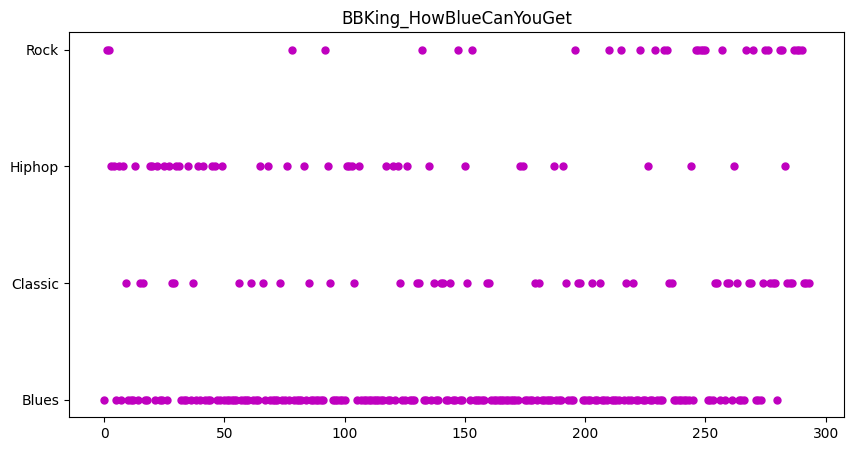


----Evaluation:----

Test Error: 
 Accuracy: 80.9%, Avg loss: 0.050920, macro F1 score: 22.36394557823129%, 
confusion matrix: 
[[263  22   7  33]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]] 



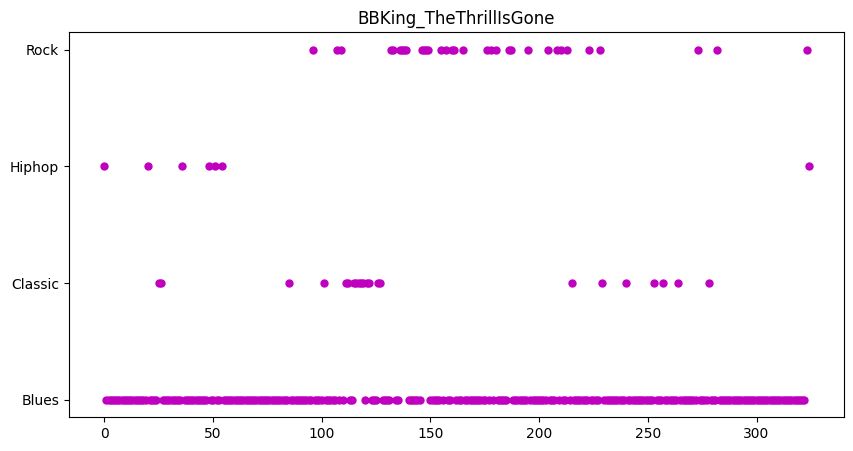

In [ ]:
for song_title in blues_urls:
    song = np.load("blues_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 0)
    song_dataset = TensorDataset(torch.tensor(song), torch.tensor(song_labels))
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=16, shuffle=False)

    (true,pred,test_loss, correct, f1, conf) = test_loop(song_dataloader, new_model, loss_fn,device)
    # Print results
    print("\n----Evaluation:----\n")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")
    plot(song_title, pred)

Ξεκινόντας με 2 τραγούδια στην κατηγορία Blues, παρατηρούμε οτι το μοντέλο μας έχει προβλέψει με επιτυχία την κατηγορία και των 2 τραγουδιών με 172/313 και 263/325.


----Evaluation:----

Test Error: 
 Accuracy: 99.3%, Avg loss: 0.003676, macro F1 score: 33.209417596034704%, 
confusion matrix: 
[[  0   0   0   0]
 [  1 268   0   1]
 [  0   0   0   0]
 [  0   0   0   0]] 



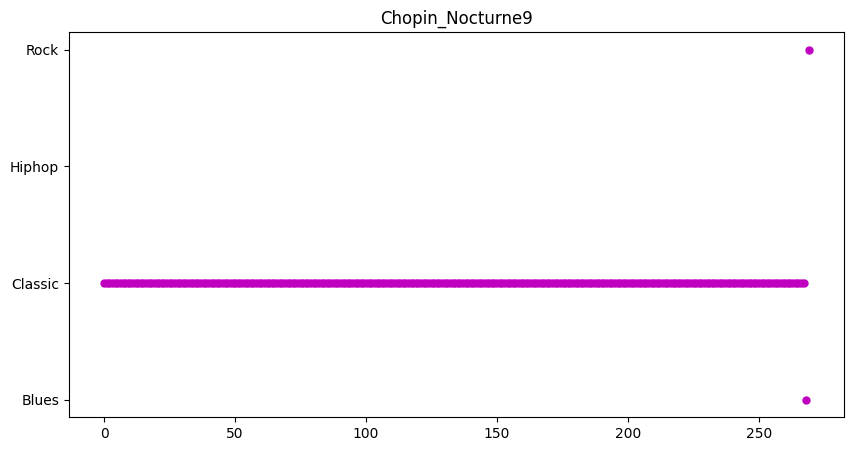

In [ ]:
for song_title in classical_urls:
    song = np.load("classical_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 1)
    song_dataset = TensorDataset(torch.tensor(song), torch.tensor(song_labels))
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=16, shuffle=False)

    (true,pred,test_loss, correct, f1, conf) = test_loop(song_dataloader, new_model, loss_fn,device)
    # Print results
    print("\n----Evaluation:----\n")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")
    plot(song_title, pred)

Συνεχίζουμε με ενα κλασσικο τραγούδι και εδώ βλέπουμε τέλειο ποσοστό επιτυχίας 268/270, και είναι λογικό καθώς το συγκεκριμένο τραγούδι έχει καθαρούς ήχους απο πιάνο, κάνοντας πολυ εύκολο να προβλεθεί.


----Evaluation:----

Test Error: 
 Accuracy: 27.2%, Avg loss: 0.093056, macro F1 score: 10.705882352941176%, 
confusion matrix: 
[[  0   0   0   0]
 [  0   0   0   0]
 [ 73  47  91 123]
 [  0   0   0   0]] 



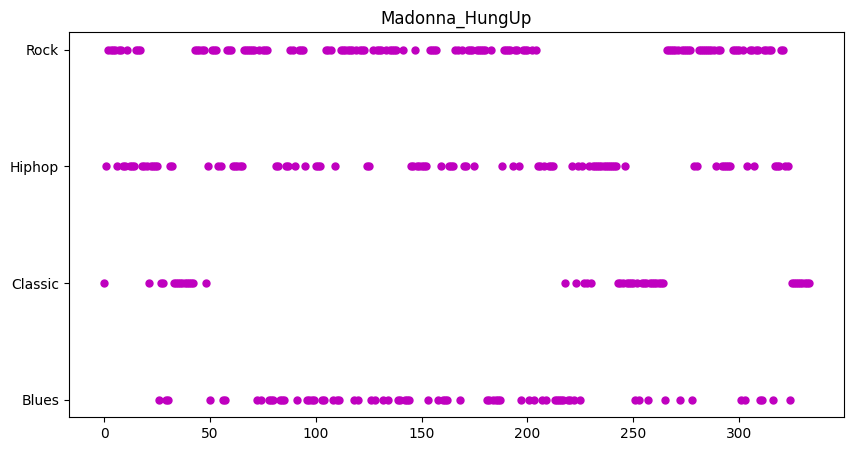


----Evaluation:----

Test Error: 
 Accuracy: 99.2%, Avg loss: 0.017017, macro F1 score: 49.797570850202426%, 
confusion matrix: 
[[  0   0   0   0]
 [  0   0   0   0]
 [  2   0 246   0]
 [  0   0   0   0]] 



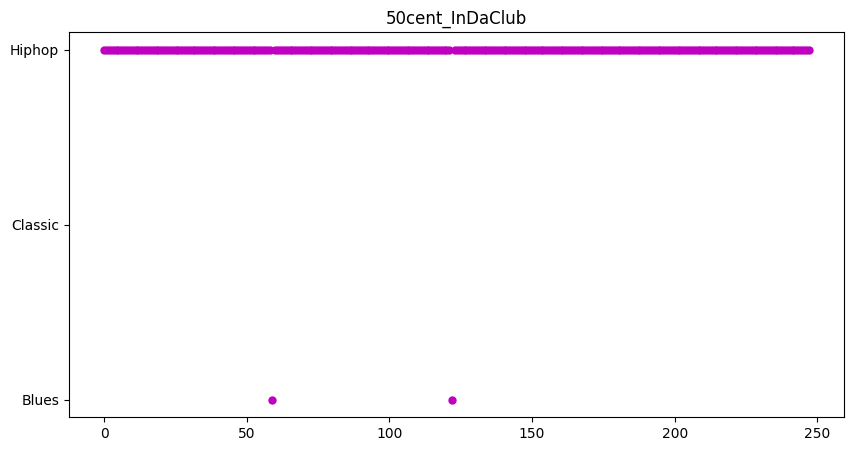

In [ ]:
for song_title in hiphop_urls:
    song = np.load("hiphop_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 2)
    song_dataset = TensorDataset(torch.tensor(song), torch.tensor(song_labels))
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=16, shuffle=False)

    (true,pred,test_loss, correct, f1, conf) = test_loop(song_dataloader, new_model, loss_fn,device)
    # Print results
    print("\n----Evaluation:----\n")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")
    plot(song_title, pred)

Για την κατηγορία hip-hop, έχουμε χρησιμοποιήσει 2 τραγούδια και αυτό γιατί το 1ο είναι κυρίως pop.Βλέπουμε πως το μοντέλο δεν έχει κάνει τέλεια πρόβλεψη ωστόσο στο 2ο τραγούδι που ειναι καθαρά hip-hop,η πρόβλεψη ειναι τέλεια με 246/248.


----Evaluation:----

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.037546, macro F1 score: 23.65853658536585%, 
confusion matrix: 
[[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [  6  14   2 194]] 



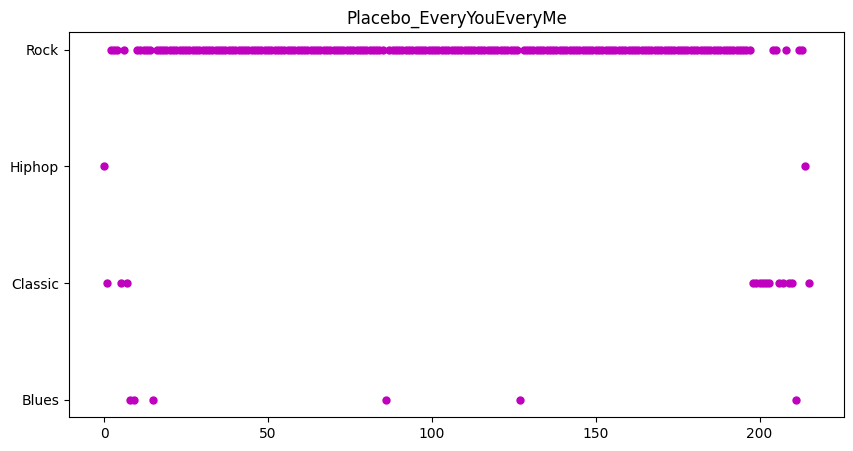

In [ ]:
for song_title in rock_urls:
    song = np.load("rock_"+song_title+"_melgrams.npy")
    song_labels = np.full(len(song), 3)
    song_dataset = TensorDataset(torch.tensor(song), torch.tensor(song_labels))
    song_dataloader = DataLoader(dataset=song_dataset, batch_size=16, shuffle=False)

    (true,pred,test_loss, correct, f1, conf) = test_loop(song_dataloader, new_model, loss_fn,device)
    # Print results
    print("\n----Evaluation:----\n")
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")
    plot(song_title, pred)

Τέλος βλέπουμε πως το μοντέλο μας ανταποκρίνεται πολύ καλα και στο rock τραγουδι προβλέποντας το σωστά, και έτσι καταλήγουμε στο συμπέρασμα πως το μοντέλο έχει προβλέψει σωστά ολα τα τραγούδια με μέσο όρο accuracy=75% το οποίο ειναι πολύ κοντάς σε αυτό που βρήκαμε χρησιμοποιόντας το test dataset.

Ωστόσο πρέπει να σημειωθεί πως η ακρίβεια για ένα συγκεκριμένο τραγούδι δεν χρειάζεται να είναι >= 50% προκειμένου να ταξινομηθεί το τραγούδι σε μια συγκεκριμένη κατηγορία, αφού κατατάσσουμε το τραγούδι στην κατηγορία με τον μεγαλύτερο αριθμό προβλεπόμενων περιπτώσεων.